In [2]:
# Load libs:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from glob import glob
from os.path import dirname, abspath, join, exists

from clearml import Task

from sklearn import linear_model

from amplify.data import DataGenerator, DataSplit

In [3]:
# ClearML Stuff
task = Task.init(project_name="amplify", task_name="predict_power_gen_initial_model")

ClearML Task: overwriting (reusing) task id=5b218fddf3274b1a8ceb82c5d6360316
ClearML results page: https://app.clear.ml/projects/f0e0b096252d4c18b9005e580afc5bce/experiments/5b218fddf3274b1a8ceb82c5d6360316/output/log


## Load Data

In [4]:
# DataGenerator - ClearML
xy_data = DataGenerator().load_data()
xy_data.head()

ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Info: Successfully loaded building data!
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start
Info: Successfully loaded weather data!


,temp,pressure,humidity,clouds_all,azimuth,irradiance,day_of_week,solar,usage
2021-10-19 04:00:00+00:00,10.07,1017.0,66.0,20.0,338.241954,0.0,2,1.0,11.3
2021-10-19 05:00:00+00:00,9.51,1017.0,70.0,20.0,7.143008,0.0,2,1.0,13.2
2021-10-19 06:00:00+00:00,9.28,1017.0,71.0,20.0,34.060157,0.0,2,1.0,12.7
2021-10-19 07:00:00+00:00,9.12,1017.0,72.0,20.0,54.265435,0.0,2,1.0,17.2
2021-10-19 08:00:00+00:00,9.12,1017.0,73.0,20.0,69.007555,0.0,2,1.0,17.0


In [5]:
# What is the shape of the data?
print(f"XY Data Shape: {xy_data.shape}")

XY Data Shape: (1994, 9)


In [6]:
# Lets see a few more rows
xy_data.head(20)

,temp,pressure,humidity,clouds_all,azimuth,irradiance,day_of_week,solar,usage
2021-10-19 04:00:00+00:00,10.07,1017.0,66.0,20.0,338.241954,0.000000,2,1.0,11.3
2021-10-19 05:00:00+00:00,9.51,1017.0,70.0,20.0,7.143008,0.000000,2,1.0,13.2
2021-10-19 06:00:00+00:00,9.28,1017.0,71.0,20.0,34.060157,0.000000,2,1.0,12.7
2021-10-19 07:00:00+00:00,9.12,1017.0,72.0,20.0,54.265435,0.000000,2,1.0,17.2
2021-10-19 08:00:00+00:00,9.12,1017.0,73.0,20.0,69.007555,0.000000,2,1.0,17.0
2021-10-19 09:00:00+00:00,8.91,1017.0,75.0,1.0,80.588008,0.000000,2,1.0,14.2
2021-10-19 10:00:00+00:00,8.61,1018.0,75.0,1.0,90.606400,0.000000,2,1.0,14.4
2021-10-19 11:00:00+00:00,8.97,1018.0,73.0,1.0,100.107523,0.000000,2,1.0,14.1
2021-10-19 12:00:00+00:00,9.12,1018.0,75.0,1.0,109.881151,323.335022,2,11.3,12.5
2021-10-19 13:00:00+00:00,10.96,1019.0,69.0,1.0,120.654281,680.919505,2,24.9,13.7


In [7]:
# timestamp example
xy_data.index[0]

Timestamp('2021-10-19 04:00:00+0000', tz='UTC', freq='H')

In [8]:
# Data Shape 
# Batch Size of 10
# Series of 7 Days 168
# (B,  S,   H, F) <-X Y-> (B,  S,   H, O)
# (20, 30, 48, 5) <-X Y-> (20, 30, 48, 1)

## Data Processing

```
1. Make xy data into a set of series of shape [N, M, F],
where N = number of examples; M = nubmer of timestamps; F = Number of features
```

```
2. Train-Test-Validation Split. Split off at 0.8, 0.1, 0.1 ratio for now. Shuffle the split.
```

```
3. Seperate x, y from dataset. Remove last column from dataset to extract y.
```

In [9]:
# Data Shape 
# Batch Size of 10
# Series of 7 Days 168
# (B,  S,   H, F) <-X Y-> (B,  S,   H, O)
# (20, 30, 48, 5) <-X Y-> (20, 30, 48, 1)
train_ds, val_ds, test_ds = DataSplit(xy_data).split_data()

In [10]:
# Isolate XY from datasets
x_train, y_solar_train, y_usage_train = (
    train_ds[0].astype("float32"),
    train_ds[1].astype("float32"),
    train_ds[2].astype("float32"),
)  # Training data
x_val, y_solar_val, y_usage_val = (
    val_ds[0].astype("float32"),
    val_ds[1].astype("float32"),
    val_ds[2].astype("float32"),
)  # Validation data
x_test, y_solar_test, y_usage_test = (
    test_ds[0].astype("float32"),
    test_ds[1].astype("float32"),
    test_ds[2].astype("float32"),
)  # Test data


In [11]:
# format data for training...
# [1,2,....] <= was a column
# do we do (n, 1, n timesteps, n features per timestep) (3,4,5 => 2 days)?

### Reviewing Data

In [12]:
# x_train shape
print("x_train shape")
x_train.shape

x_train shape


(519, 48, 7)

In [13]:
# y_train shape
print("y_solar_train shape")
y_solar_train.shape

y_solar_train shape


(519, 48, 1)

## Modeling

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from keras import Input
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.layers import Bidirectional
from keras.layers import TimeDistributed

### Normalize Data

In [15]:
#TODO: Move to model pipeline
# Normalize X_train data
norm_layer = tf.keras.layers.Normalization(axis=-1)
norm_layer.adapt(x_train)

2022-01-30 13:49:41.727679: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-30 13:49:41.902409: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [16]:
# Testing out this normalization
x_train_norm = norm_layer(x_train)
x_val_norm = norm_layer(x_val)

## Simple LSTM

In [17]:
def SimpleLSTM(n_layer=1, n_series_len=48, n_series_ft=6, n_series_out=1, activation_f='tanh'):
    lstm_input = Input(shape=(n_series_len, n_series_ft))
    lstm_layer = LSTM(n_layer, activation=activation_f, return_sequences=True)(lstm_input)
    x = TimeDistributed(Dense(n_series_out))(lstm_layer)
    #x = Dense(n_outputs)(lstm_layer)
    model = Model(inputs=lstm_input, outputs=x)
    return model

In [18]:
def SimpleLSTM_UsingSequential(n_layer=1, n_series_len=48, n_series_ft=6, n_series_out=1, activation_f='tanh'):
    model = Sequential()
    model.add(LSTM(n_layer, activation=activation_f, input_shape=(n_series_len, n_series_ft), return_sequences=True))
    model.add(TimeDistributed(Dense(n_series_out)))
    return model

In [25]:
n_layer = 10
n_series_len = 48
n_series_ft = 7
n_series_out = 1        # so actual output shape = [n_series_len, n_series_out]
activation_f='tanh'

In [26]:
#model = SimpleLSTM(n_layer, n_series_len, n_series_ft, n_series_out, activation_f)

In [27]:
model =  SimpleLSTM_UsingSequential(n_layer, n_series_len, n_series_ft, n_series_out, activation_f)

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 48, 10)            720       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 48, 1)             11        
Total params: 731
Trainable params: 731
Non-trainable params: 0
_________________________________________________________________


In [29]:
#optimizer = keras.optimizers.Adam(learning_rate=0.001)
#model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=optimizer)
#model.compile(tf.optimizers.Adam(learning_rate=0.0003),
#      loss='binary_crossentropy',
#      metrics=['acc'])
model.compile(tf.optimizers.Adam(learning_rate=0.001),
      loss=keras.losses.Huber(),
      metrics=[keras.metrics.RootMeanSquaredError()])

# So, we tried with a fixed learning rate, and this sucks...

In [30]:
history = model.fit(
    x=x_train_norm,
    y=y_solar_train,
    epochs=30,
    batch_size=10,
    validation_data=(x_val_norm, y_solar_val),
    shuffle=False,
)


Epoch 1/30
52/52 [==============================] - 14s 101ms/step - loss: 6.3401 - root_mean_squared_error: 11.9241 - val_loss: 6.2917 - val_root_mean_squared_error: 11.9396
Epoch 2/30
52/52 [==============================] - 3s 50ms/step - loss: 6.0099 - root_mean_squared_error: 11.6134 - val_loss: 5.9574 - val_root_mean_squared_error: 11.5208
Epoch 3/30
52/52 [==============================] - 2s 37ms/step - loss: 5.6535 - root_mean_squared_error: 11.0722 - val_loss: 5.6786 - val_root_mean_squared_error: 10.9434
Epoch 4/30
52/52 [==============================] - 3s 48ms/step - loss: 5.4373 - root_mean_squared_error: 10.6484 - val_loss: 5.4811 - val_root_mean_squared_error: 10.6062
Epoch 5/30
52/52 [==============================] - 5s 93ms/step - loss: 5.2516 - root_mean_squared_error: 10.3222 - val_loss: 5.2780 - val_root_mean_squared_error: 10.2646
Epoch 6/30
52/52 [==============================] - 3s 48ms/step - loss: 5.0721 - root_mean_squared_error: 9.9987 - val_loss: 5.0867 

## Understanding Results

In [31]:
# Run a prediction:
pred_out = model.predict(x_val_norm)
pred_out.shape

(65, 48, 1)

In [32]:
# compare to y shape
y_solar_val.shape

(65, 48, 1)

In [33]:
# lets see a few of these (just showing the final entry)
limited_view = pred_out[:5]
limited_view.shape

(5, 48, 1)

In [34]:
# Comparing to actual values
limited_y = y_solar_val[:5,]
limited_y.shape

(5, 48, 1)

In [35]:
reshape_out = limited_y[0].reshape((limited_y.shape[2], limited_y.shape[1]))
print(reshape_out)

[[ 0.1  0.1  0.1  0.1  0.1  0.1  2.9  8.1 16.  17.9 14.8 15.6 15.7  7.3
   0.4  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8
   0.8  0.8  0.8  1.5  2.   2.7  4.9  7.   3.3  9.5  9.5  9.5  9.5  9.5
   9.5  9.5  9.5  9.5  9.5  9.5]]


In [36]:
def PrintPredVsY(pred_out, y_gt, num_row, num_ts):
    limited_pred = pred_out[:num_row, -num_ts:]
    limited_y = y_gt[:num_row, -num_ts:]

    for i in range(num_row):
        flatten_row_pred = limited_pred[i].reshape((num_ts))
        flatten_row_y = limited_y[i].reshape((num_ts))
        print(f"--- Row {i} ---")
        print(f"Y_Pred: {np.round(flatten_row_pred, 1)}")
        print(f"Y     : {np.round(flatten_row_y, 1)}")

In [37]:
PrintPredVsY(pred_out, y_solar_val, num_row=10, num_ts=5)

--- Row 0 ---
Y_Pred: [1.5 1.5 1.6 1.1 1.2]
Y     : [9.5 9.5 9.5 9.5 9.5]
--- Row 1 ---
Y_Pred: [1.9 2.5 3.5 4.7 9. ]
Y     : [0.5 0.5 0.5 0.5 8.4]
--- Row 2 ---
Y_Pred: [16.2 15.5 13.2  6.7  1.4]
Y     : [31.8 28.3 19.5  8.4  0.6]
--- Row 3 ---
Y_Pred: [16.3 14.2  9.8  3.4  1. ]
Y     : [ 7.2 10.3  7.1 10.1  0.8]
--- Row 4 ---
Y_Pred: [1.1 1.6 2.1 3.  3.6]
Y     : [1.1 1.1 1.1 1.1 1.1]
--- Row 5 ---
Y_Pred: [1.6 1.6 1.6 1.7 1. ]
Y     : [0.2 0.2 0.2 0.2 0.2]
--- Row 6 ---
Y_Pred: [1.6 1.5 1.5 1.6 1.7]
Y     : [2.7 2.7 2.7 2.7 2.7]
--- Row 7 ---
Y_Pred: [0.8 1.4 1.8 2.6 3.9]
Y     : [1.6 1.6 1.6 1.6 1.6]
--- Row 8 ---
Y_Pred: [3.3 0.7 1.5 1.6 1.4]
Y     : [4.4 0.3 3.8 3.8 3.8]
--- Row 9 ---
Y_Pred: [1.  1.3 1.6 2.  2.4]
Y     : [0.6 0.6 0.6 0.6 0.6]


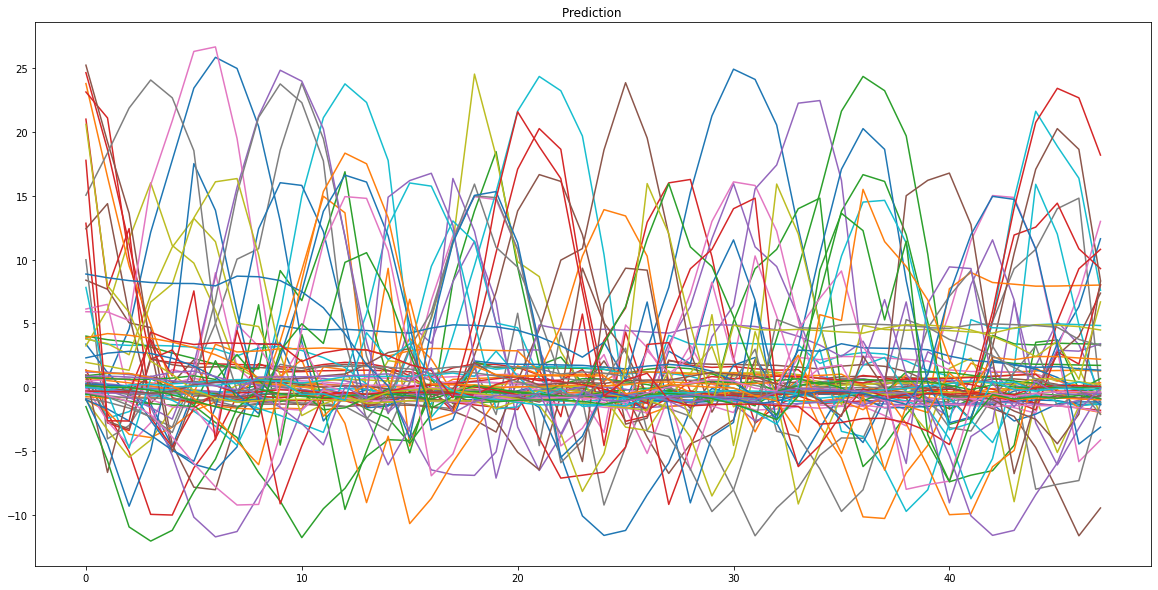

In [38]:
x_test_norm = norm_layer(x_test)
y_solar_preds = model.predict(x_test_norm)
plt.figure(figsize=(20, 10))
plt.title('Prediction ')
for x in range(y_solar_preds.shape[0]):
    #plt.plot(y_solar_preds[x])
    plt.plot(y_solar_test[x] - y_solar_preds[x])

plt.show()

In [39]:
#Helper functions for this:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [40]:
#y_solar_test.shape
#y_solar_test

In [41]:
#y_mae = keras.losses.mean_absolute_error(y_solar_test, y_solar_preds)
#y_mae.shape

In [42]:
#plt.figure()
#plt.plot(y_mae[1])
#plt.show()

In [43]:
# N = [3, 3 ,1]
x_m = np.array([[1.1, 2, 3], [1.2, 5, 3], [1.3, 5, 3]], np.float32)
x_m = x_m.reshape((3,3,1))
x_m
#y_manual_mae = 100. * np.mean(np.abs((y_solar_test - y_pred) / y_true), axis=-1))

array([[[1.1],
        [2. ],
        [3. ]],

       [[1.2],
        [5. ],
        [3. ]],

       [[1.3],
        [5. ],
        [3. ]]], dtype=float32)

In [44]:
y_manual_mae = np.mean(np.abs((x_m)), axis=0)
y_manual_mae

array([[1.2],
       [4. ],
       [3. ]], dtype=float32)

In [45]:
def calc_mape(y_true, y_pred, axis):
    abs_error = np.abs((y_true - y_pred) / y_true)
    mape = 100. * np.mean(abs_error, axis=axis)
    return mape

def calc_mae(y_true, y_pred, axis):
    abs_error = np.abs(y_true - y_pred)
    mae = np.mean(abs_error, axis=axis)
    return mae

def plot_all_error(y_pred, y_actual):
    plt.figure(figsize=(20, 10))
    plt.title('Prediction Error')
    for x in range(y_pred.shape[0]):
        #plt.plot(y_solar_preds[x])
        plt.plot(y_actual[x] - y_pred[x])

    plt.show()

    plt.title('Prediction Mean Absolute Prediction Error')
    #y_mae = keras.losses.mean_absolute_error(y_actual, y_pred)
    y_mape_0 = calc_mape(y_actual, y_pred, axis=0)
    y_mape_1 = calc_mape(y_actual, y_pred, axis=1)
    plt.plot(y_mape_0)
    plt.plot(y_mape_1)
    plt.ylabel("Percent Error")
    plt.xlabel("Observation/Hour")
    plt.legend(['mape_by_hour', 'mape_by_observation'], loc='upper left')
    plt.show()

    plt.title('Prediction Mean Absolute Percentage Error')
    #y_mape = keras.losses.mean_absolute_percentage_error(y_actual, y_pred)
    y_mae_0 = calc_mae(y_actual, y_pred, axis=0)
    y_mae_1 = calc_mae(y_actual, y_pred, axis=1)
    plt.plot(y_mae_0)
    plt.plot(y_mae_1)
    plt.ylabel("kW")
    plt.xlabel("Observation/Hour")
    plt.legend(['mae_by_hour', 'mae_by_observation'], loc='upper left')
    plt.show()
      

In [46]:
def plot_history(history, metric):
    # This function will plot the model fit process
    print(history.history.keys())
    # summarize history for accuracy
    if metric == "root_mean_squared_error":
        plt.plot(history.history['root_mean_squared_error'])
        plt.plot(history.history['val_root_mean_squared_error'])
        plt.title('model RMSE')
        plt.ylabel('RMSE')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    elif metric == "mean_absolute_percentage_error":
        plt.plot(history.history["mean_absolute_percentage_error"])
        plt.plot(history.history["val_mean_absolute_percentage_error"])
        plt.title('model MAPE')
        plt.ylabel('MAPE')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    elif metric == "mean_absolute_error":
        plt.plot(history.history["mean_absolute_error"])
        plt.plot(history.history["val_mean_absolute_error"])
        plt.title('model MAE')
        plt.ylabel('MAE')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


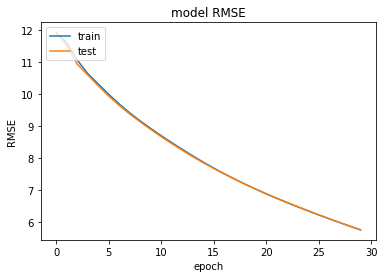

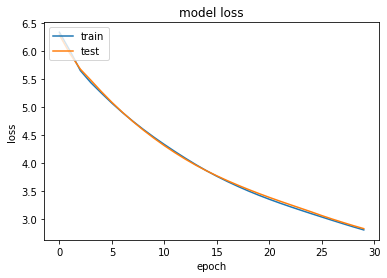

In [47]:
plot_history(history, metric="root_mean_squared_error")

## Improving The Model

### 1: Add LR scheduler

In [48]:
#Try again with this callback
reduce_lr = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

In [49]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.Huber(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(
    x=x_train_norm,
    y=y_solar_train,
    epochs=30,
    batch_size=10,
    validation_data=(x_val_norm, y_solar_val),
    shuffle=False,
    callbacks=[reduce_lr]
)

Epoch 1/30
52/52 [==============================] - 9s 71ms/step - loss: 2.7490 - root_mean_squared_error: 5.6281 - val_loss: 2.7673 - val_root_mean_squared_error: 5.6187
Epoch 2/30
52/52 [==============================] - 2s 37ms/step - loss: 2.6928 - root_mean_squared_error: 5.5049 - val_loss: 2.7182 - val_root_mean_squared_error: 5.5068
Epoch 3/30
52/52 [==============================] - 3s 53ms/step - loss: 2.6464 - root_mean_squared_error: 5.4013 - val_loss: 2.6744 - val_root_mean_squared_error: 5.4107
Epoch 4/30
52/52 [==============================] - 2s 36ms/step - loss: 2.6058 - root_mean_squared_error: 5.3115 - val_loss: 2.6358 - val_root_mean_squared_error: 5.3271
Epoch 5/30
52/52 [==============================] - 3s 60ms/step - loss: 2.5700 - root_mean_squared_error: 5.2330 - val_loss: 2.6017 - val_root_mean_squared_error: 5.2542
Epoch 6/30
52/52 [==============================] - 3s 62ms/step - loss: 2.5383 - root_mean_squared_error: 5.1640 - val_loss: 2.5714 - val_root_m

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error', 'lr'])


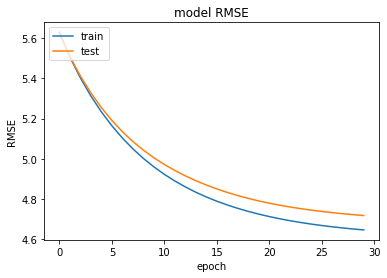

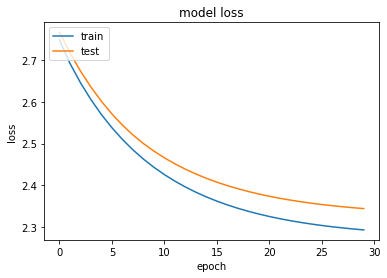

In [50]:
plot_history(history, metric="root_mean_squared_error")

In [51]:
# Prediction:
x_test_norm = norm_layer(x_test)
y_solar_preds = model.predict(x_test_norm)

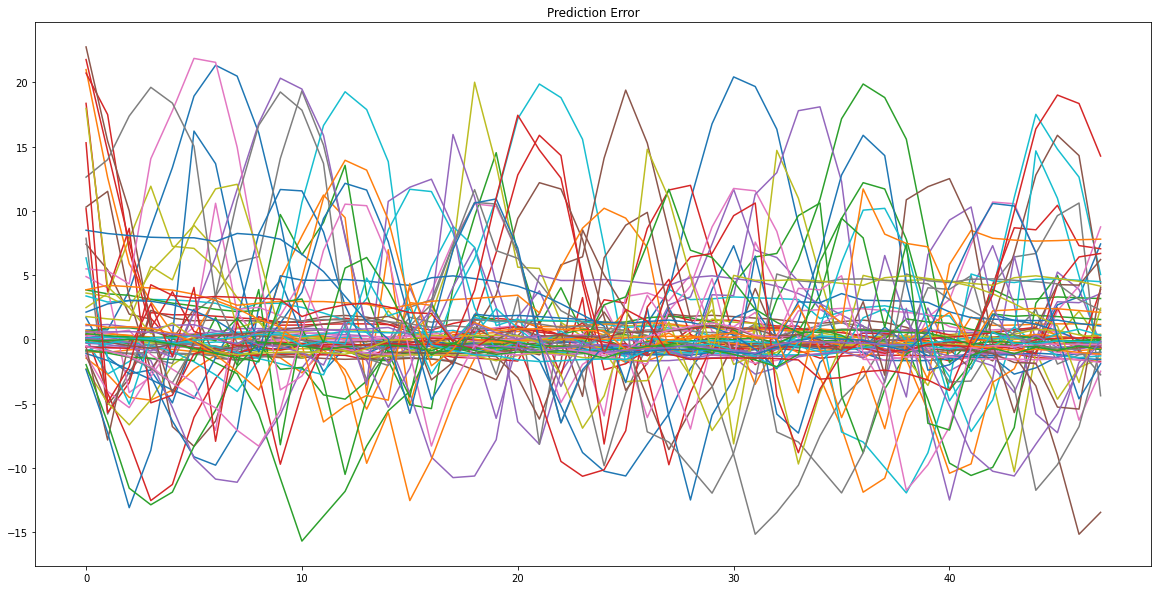

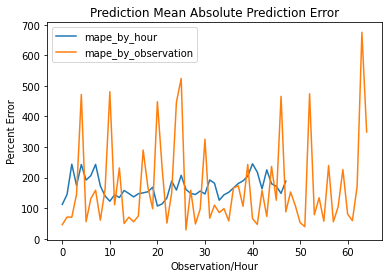

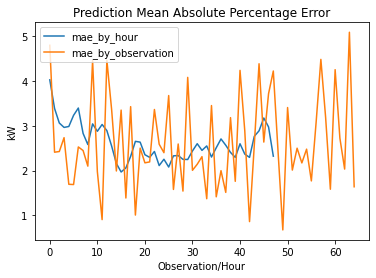

In [52]:
plot_all_error(y_pred=y_solar_preds, y_actual=y_solar_test)

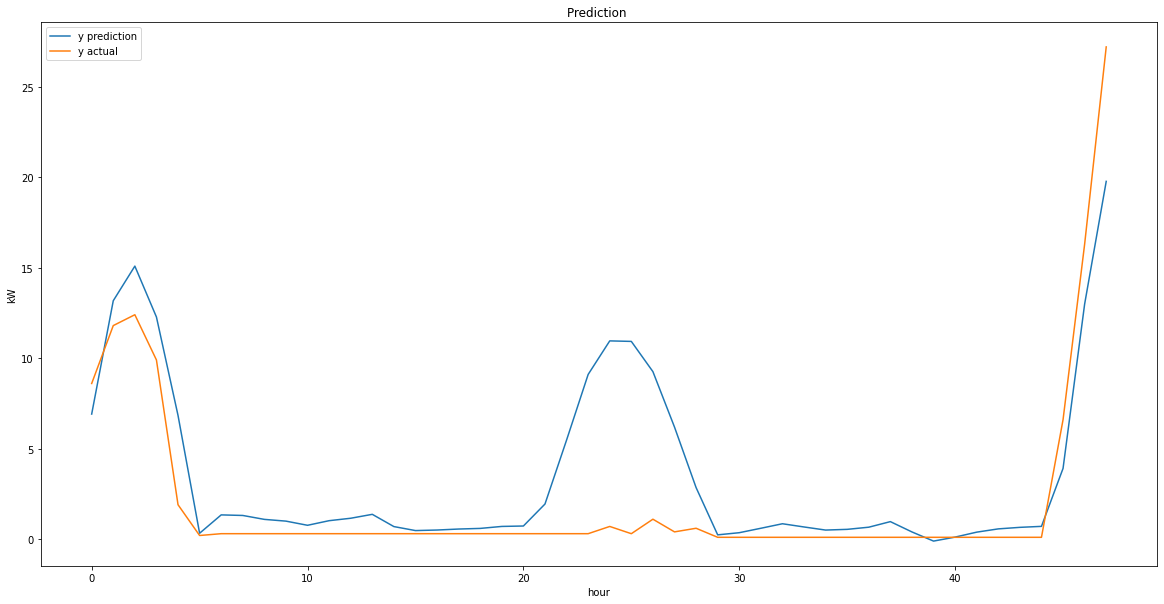

In [53]:
rng = np.random.default_rng(seed=42)
plt.figure(figsize=(20, 10))
plt.title('Prediction ')
x = np.random.default_rng().integers(0,y_solar_preds.shape[0])
plt.plot(y_solar_preds[x])
plt.plot(y_solar_test[x])
plt.ylabel('kW')
plt.xlabel('hour')
plt.legend(['y prediction', 'y actual'], loc='upper left')

plt.show()

In [54]:
def plot_random_comparison(y_pred, y_actual):
    rng = np.random.default_rng(seed=42)
    plt.figure(figsize=(20, 10))
    x = np.random.default_rng().integers(0, y_pred.shape[0])
    plt.title(f"Random Prediction Plot, Test Observation {x}")
    plt.plot(y_pred[x])
    plt.plot(y_actual[x])
    plt.ylabel('kW')
    plt.xlabel('hour')
    plt.legend(['y prediction', 'y actual'], loc='upper left')

    plt.show()

### Improving Metrics:
```
Without understanding our model and how accurate it is, we cannot proceede
```
Possible metrics:
1. MSE
2. RMSE
3. MAE
4. MAEP

```
MAEP
```

In [55]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.Huber(),
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
history = model.fit(
    x=x_train_norm,
    y=y_solar_train,
    epochs=30,
    batch_size=10,
    validation_data=(x_val_norm, y_solar_val),
    shuffle=False,
    callbacks=[reduce_lr]
)

Epoch 1/30
52/52 [==============================] - 7s 47ms/step - loss: 2.2775 - mean_absolute_percentage_error: 142.8897 - val_loss: 2.2963 - val_mean_absolute_percentage_error: 178.9968
Epoch 2/30
52/52 [==============================] - 1s 25ms/step - loss: 2.2328 - mean_absolute_percentage_error: 144.7396 - val_loss: 2.2576 - val_mean_absolute_percentage_error: 176.7028
Epoch 3/30
52/52 [==============================] - 1s 27ms/step - loss: 2.1962 - mean_absolute_percentage_error: 143.9770 - val_loss: 2.2243 - val_mean_absolute_percentage_error: 175.6738
Epoch 4/30
52/52 [==============================] - 1s 25ms/step - loss: 2.1642 - mean_absolute_percentage_error: 143.4741 - val_loss: 2.1953 - val_mean_absolute_percentage_error: 175.2386
Epoch 5/30
52/52 [==============================] - 1s 25ms/step - loss: 2.1361 - mean_absolute_percentage_error: 143.0938 - val_loss: 2.1700 - val_mean_absolute_percentage_error: 174.7533
Epoch 6/30
52/52 [==============================] - 2s 

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error', 'lr'])


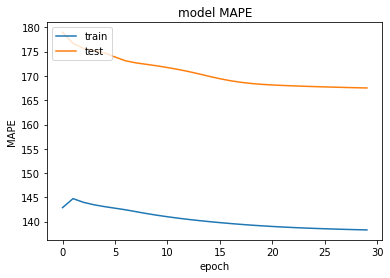

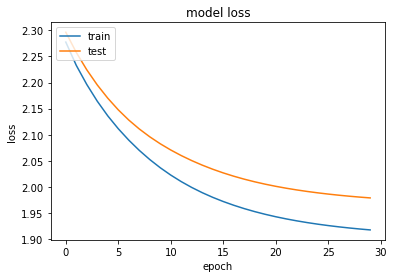

In [56]:
plot_history(history, metric="mean_absolute_percentage_error")

In [57]:
# Prediction:
x_test_norm = norm_layer(x_test)
y_solar_preds = model.predict(x_test_norm)

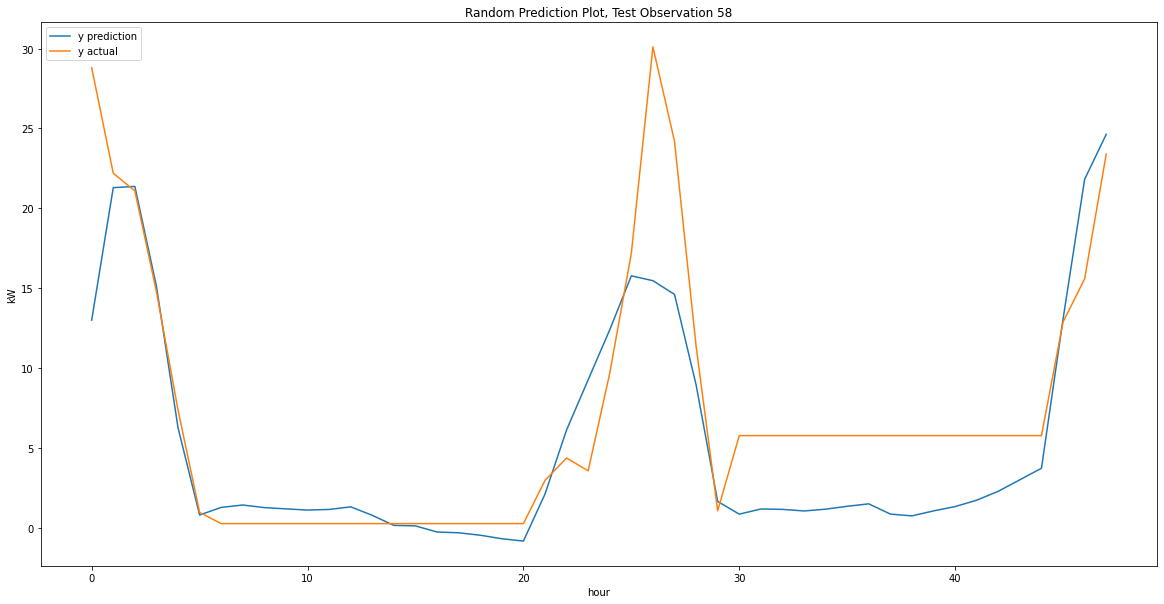

In [58]:
plot_random_comparison(y_solar_preds, y_solar_test)

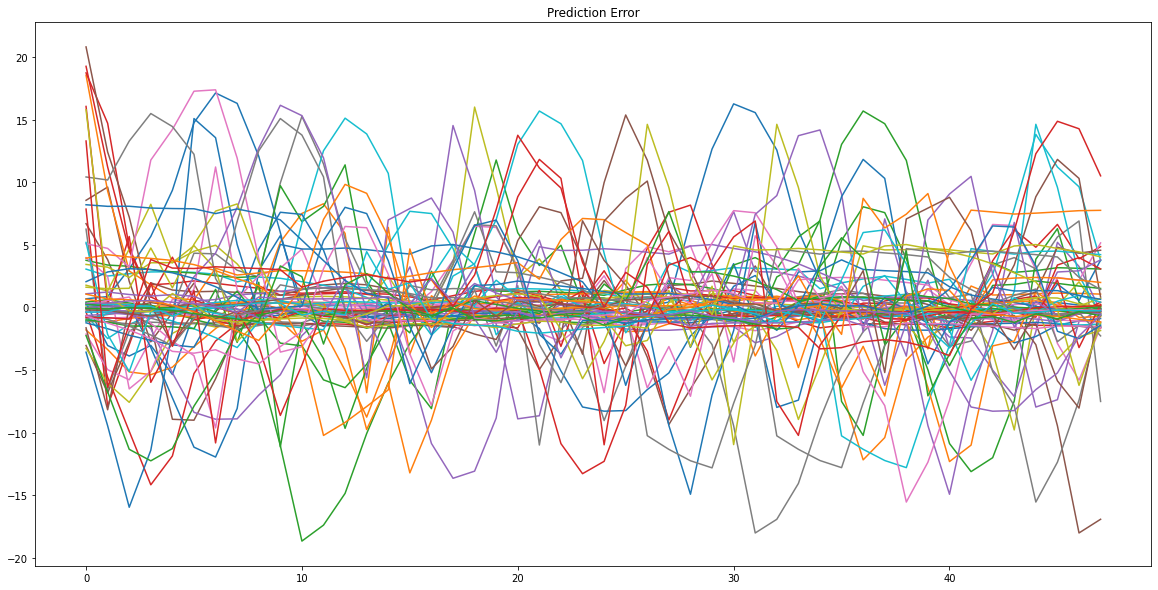

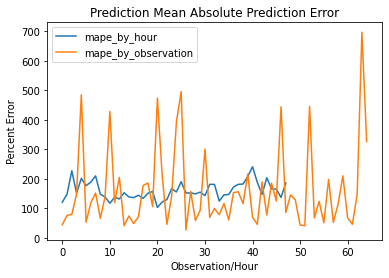

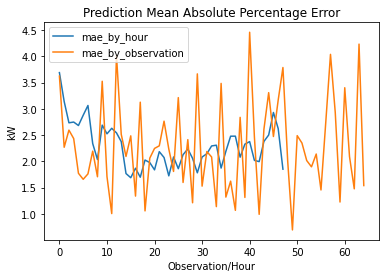

In [59]:
plot_all_error(y_solar_preds, y_solar_test)

This seems to be intuitive enough to understand. I will try now just MAE

```
MAE
```

In [60]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.Huber(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = model.fit(
    x=x_train_norm,
    y=y_solar_train,
    epochs=30,
    batch_size=10,
    validation_data=(x_val_norm, y_solar_val),
    shuffle=True,
    callbacks=[reduce_lr]
)

Epoch 1/30
52/52 [==============================] - 5s 33ms/step - loss: 1.9133 - mean_absolute_error: 2.3218 - val_loss: 1.9474 - val_mean_absolute_error: 2.3645
Epoch 2/30
52/52 [==============================] - 1s 20ms/step - loss: 1.8768 - mean_absolute_error: 2.2843 - val_loss: 1.9184 - val_mean_absolute_error: 2.3324
Epoch 3/30
52/52 [==============================] - 1s 20ms/step - loss: 1.8484 - mean_absolute_error: 2.2557 - val_loss: 1.8893 - val_mean_absolute_error: 2.3049
Epoch 4/30
52/52 [==============================] - 2s 29ms/step - loss: 1.8242 - mean_absolute_error: 2.2294 - val_loss: 1.8768 - val_mean_absolute_error: 2.2930
Epoch 5/30
52/52 [==============================] - 1s 22ms/step - loss: 1.8061 - mean_absolute_error: 2.2120 - val_loss: 1.8574 - val_mean_absolute_error: 2.2720
Epoch 6/30
52/52 [==============================] - 2s 33ms/step - loss: 1.7859 - mean_absolute_error: 2.1914 - val_loss: 1.8418 - val_mean_absolute_error: 2.2559
Epoch 7/30
52/52 [====

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error', 'lr'])


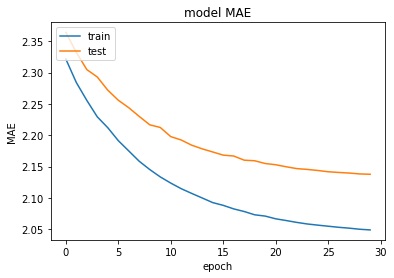

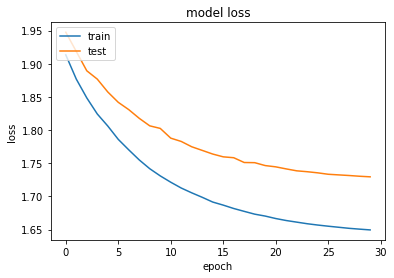

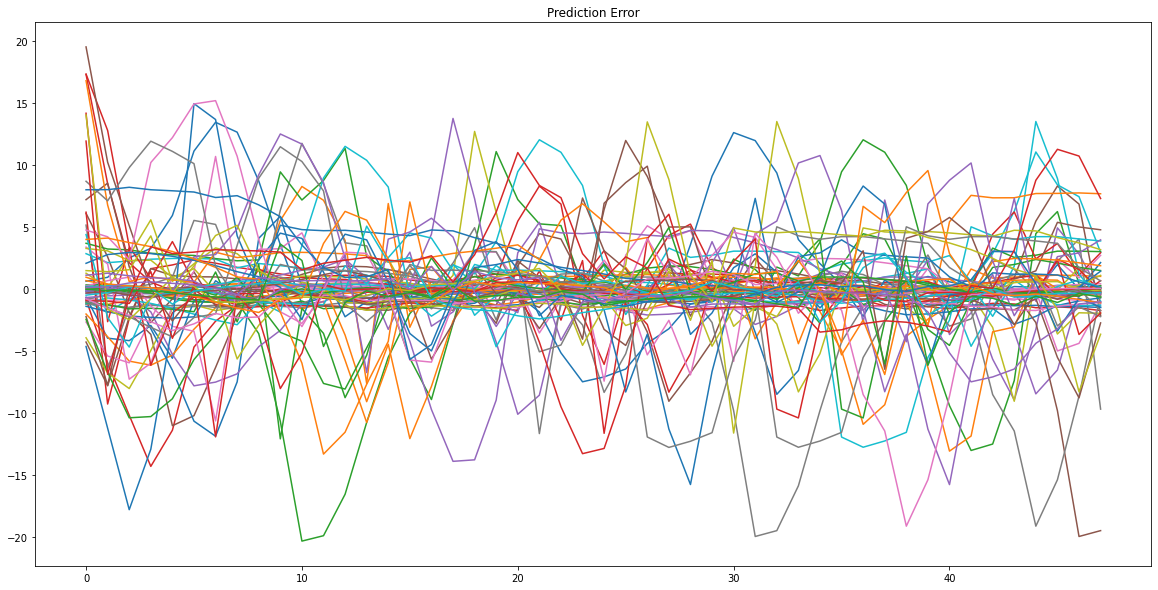

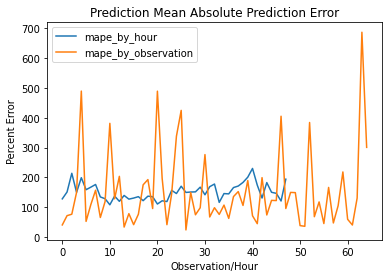

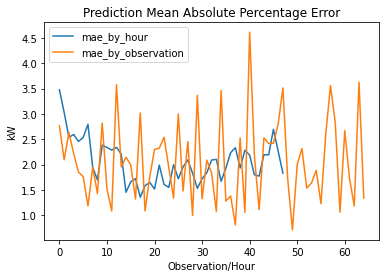

In [61]:
plot_history(history, metric="mean_absolute_error")

# Prediction:
x_test_norm = norm_layer(x_test)
y_solar_preds = model.predict(x_test_norm)
plot_all_error(y_solar_preds, y_solar_test)

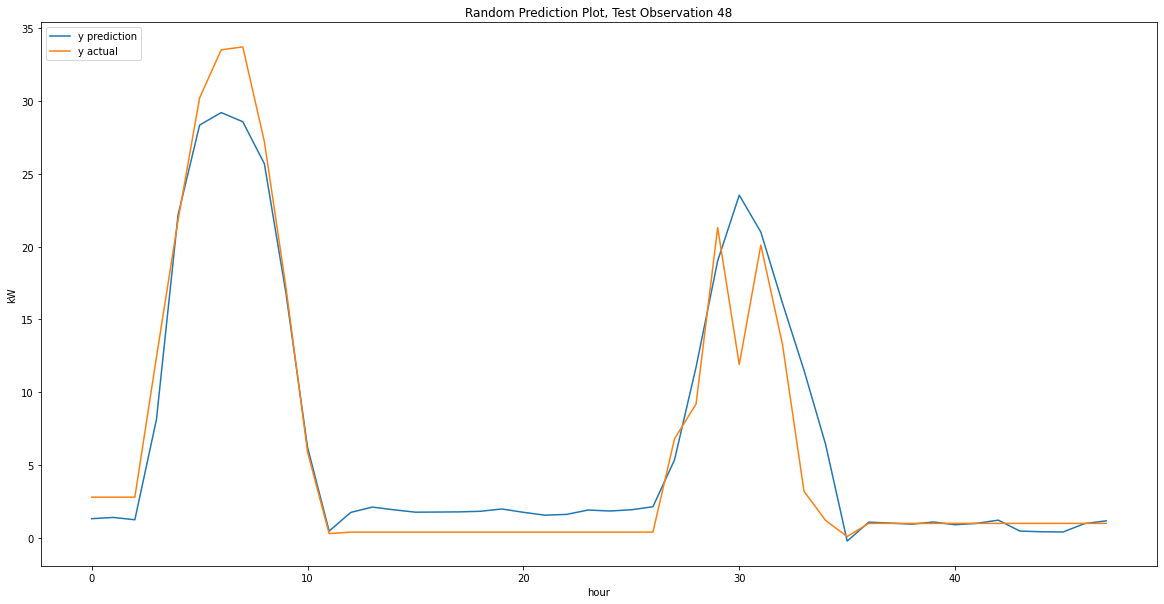

In [62]:
plot_random_comparison(y_solar_preds, y_solar_test)

In [76]:
from amplify.metrics import DataEval

In [77]:
data_eval = DataEval()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error', 'lr'])


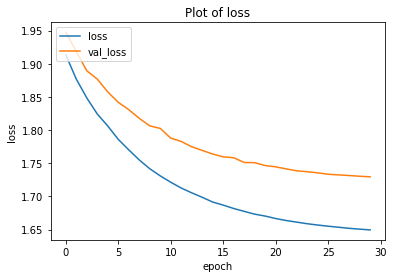

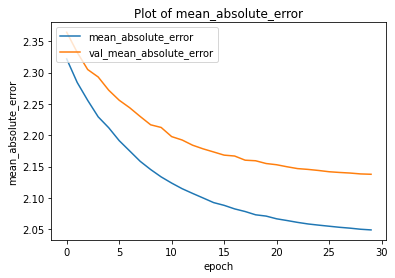

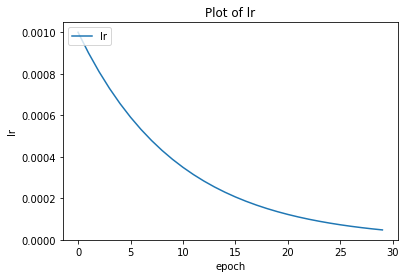

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [79]:
data_eval.EvaluateModel(model_name="SimpleLSTM_UsingSequential", model=model, history=history, x_test=x_test_norm, y_test=y_solar_test)